# Preparing the data and visualize it

In [18]:
import seaborn as sns
import pandas as pd
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [19]:
class_labels = ['cone cut', 'normal']
img_size = 224

def get_data(data_dir):
    data = [] 
    for label in class_labels: 
        path = os.path.join(data_dir, label)
        class_num = class_labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


In [20]:
# Now we can easily fetch our data.
dataset = get_data("/kaggle/input/cone-cut-erros-traintestval/dataset/test")

# randomly select 9 images from the dataset
images = []
labels = []
for i in range(9):
    index = np.random.randint(0, len(dataset))
    images.append(dataset[index][0])
    labels.append(dataset[index][1])

/tmp/ipykernel_31/3779290970.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


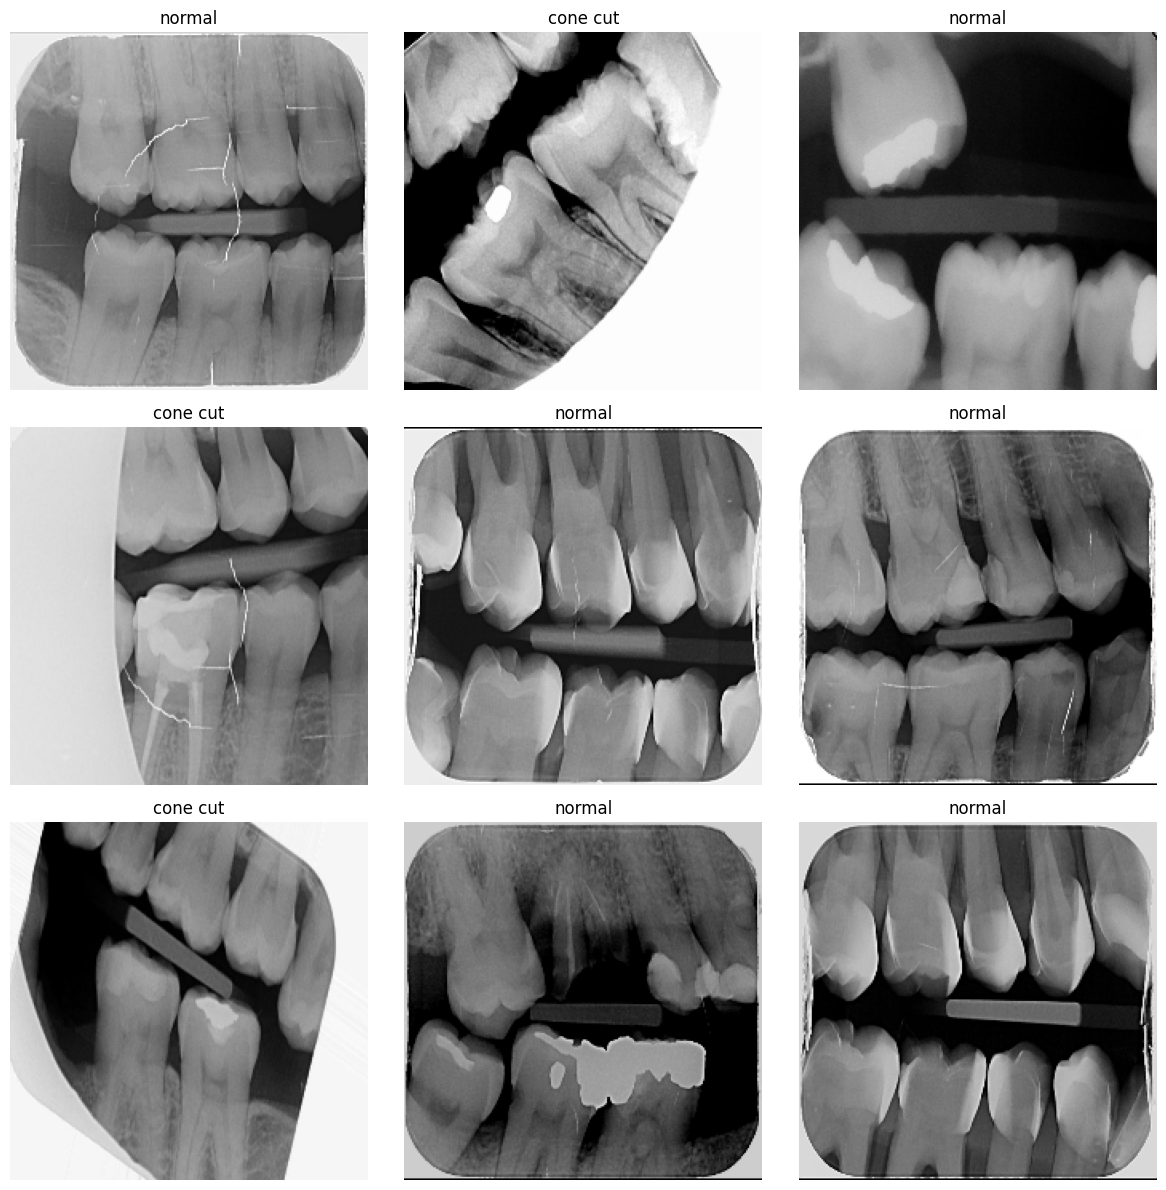

In [21]:
# create a 3x3 grid of the images with their corresponding labels

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()
for i in range(len(images)):
    axes[i].imshow(images[i])
    axes[i].set_title(class_labels[labels[i]])
    axes[i].axis('off')

# show the plot
plt.tight_layout()
plt.show()


# Creating our model

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [15]:
# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 100

# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_data = train_datagen.flow_from_directory(
    '/kaggle/input/cone-cut-erros-traintestval/dataset/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Update class_mode to 'binary' for two classes
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    '/kaggle/input/cone-cut-erros-traintestval/dataset/val',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Update class_mode to 'binary' for two classes
    subset='validation'
)

test_data = test_datagen.flow_from_directory(
    '/kaggle/input/cone-cut-erros-traintestval/dataset/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Update class_mode to 'binary' for two classes
)

Found 2824 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


In [18]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.activations import sigmoid

# Define model
base_model = ResNet50(include_top=False, input_shape=(*IMAGE_SIZE, 3), pooling='avg')
x = Dense(256, activation='relu')(base_model.output)
output = Dense(1, activation=sigmoid)(x)  # Use sigmoid activation for binary classification
model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])


In [19]:
# Train model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data
)

Epoch 1/100
89/89 [==============================] - 77s 731ms/step - loss: 0.5895 - accuracy: 0.6976 - val_loss: 0.4659 - val_accuracy: 0.8400
Epoch 2/100
89/89 [==============================] - 50s 560ms/step - loss: 0.4679 - accuracy: 0.7918 - val_loss: 0.4105 - val_accuracy: 0.8200
Epoch 3/100
89/89 [==============================] - 50s 562ms/step - loss: 0.4392 - accuracy: 0.7975 - val_loss: 0.4470 - val_accuracy: 0.7350
Epoch 4/100
89/89 [==============================] - 49s 546ms/step - loss: 0.4122 - accuracy: 0.8106 - val_loss: 0.3905 - val_accuracy: 0.8250
Epoch 5/100
89/89 [==============================] - 50s 558ms/step - loss: 0.3563 - accuracy: 0.8619 - val_loss: 0.3515 - val_accuracy: 0.8500
Epoch 6/100
89/89 [==============================] - 50s 561ms/step - loss: 0.3456 - accuracy: 0.8623 - val_loss: 0.4115 - val_accuracy: 0.8100
Epoch 7/100
89/89 [==============================] - 48s 544ms/step - loss: 0.3242 - accuracy: 0.8715 - val_loss: 0.3354 - val_accuracy:

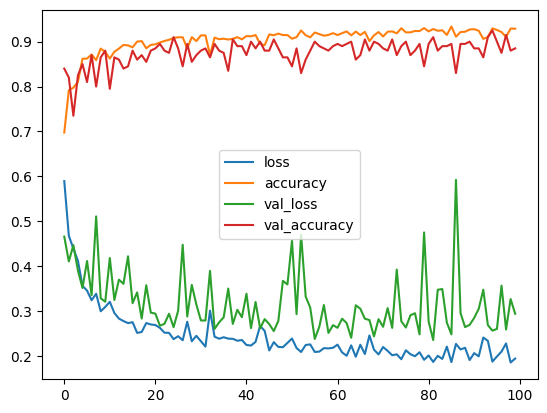

16/16 [==============================] - 7s 446ms/step - loss: 0.1913 - accuracy: 0.9209
Test loss: 0.191, accuracy: 0.921


In [20]:
# Evaluate model
pd.DataFrame(history.history).plot()
plt.show()

loss, accuracy = model.evaluate(test_data)
print(f'Test loss: {loss:.3f}, accuracy: {accuracy:.3f}')

In [39]:
# Save the model
model.save('path/to/save/model1')

In [38]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on test data
y_true = test_data.classes
y_pred_probs = model.predict(test_data)
y_pred = (y_pred_probs >= 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Print classification report
target_names = list(train_data.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names)

# Print additional metrics and report
print(f"Accuracy: {accuracy:.4f}\n")
print(report)


16/16 [==============================] - 3s 213ms/step
Accuracy: 0.4664

              precision    recall  f1-score   support

    cone cut       0.45      0.46      0.45       243
      normal       0.49      0.48      0.48       263

    accuracy                           0.47       506
   macro avg       0.47      0.47      0.47       506
weighted avg       0.47      0.47      0.47       506



16/16 [==============================] - 4s 228ms/step


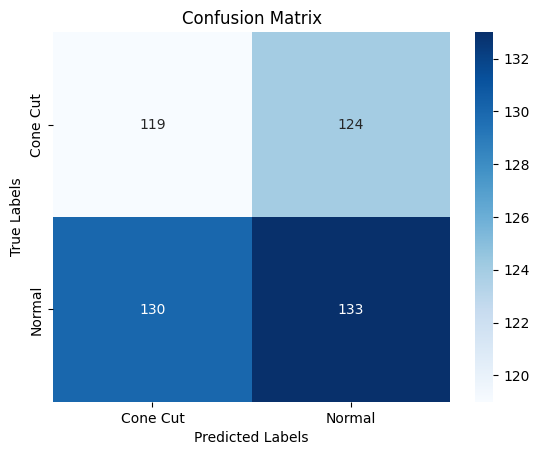

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_true = test_data.classes
y_pred_probs = model.predict(test_data)

# Convert probabilities to predicted labels (0 or 1)
y_pred = (y_pred_probs >= 0.5).astype(int)

# Get confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define target class names
target_names = ['Cone Cut', 'Normal']

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


1/1 [==============================] - 0s 30ms/step
Image: /kaggle/input/cone-cut-erros-traintestval/dataset/test/cone cut/cone cut 1005.jpg - Predicted Label: Cone Cut


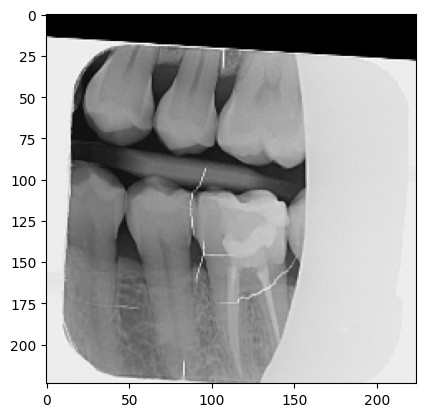

1/1 [==============================] - 0s 30ms/step
Image: /kaggle/input/cone-cut-erros-traintestval/dataset/test/normal/normal 100.jpg - Predicted Label: Normal


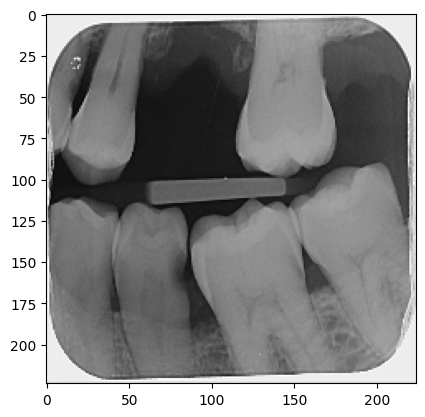

Predicted Labels: ['Cone Cut', 'Normal']


In [36]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Test model with some images
test_images = [
    '/kaggle/input/cone-cut-erros-traintestval/dataset/test/cone cut/cone cut 1005.jpg',
    '/kaggle/input/cone-cut-erros-traintestval/dataset/test/normal/normal 100.jpg'
]
labels = []
dic = {0: 'Cone Cut', 1: 'Normal'}  # Dictionary to map class indices to labels

for img_path in test_images:
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # resize image
    img = np.array(img, dtype=np.float32)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    preds = model.predict(img)
    label = 1 if preds[0] >= 0.5 else 0  # Classify based on threshold
    labels.append(label)
    print(f'Image: {img_path} - Predicted Label: {dic[label]}')
    plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
    plt.show()

# Print predicted labels
print('Predicted Labels:', [dic[label] for label in labels])
